# Plotting data from "Twins & Weirdos" w/ UMAP
https://arxiv.org/pdf/1711.00022.pdf  
https://github.com/ireis/APOGEE  

In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
#import seaborn as sns

import umap
import umap.plot

%matplotlib inline

In [5]:
# This is 23 GB, probably need more RAM to load??
# Will start with just reading small chunks to get a look at data

data = np.load('full_dmat_f2.npy',mmap_mode='r')


In [11]:
# Let's load a significantly smaller matrix and umap it
dim = 10000
X = data[:dim,:dim]

In [25]:
print(X)

[[0.     0.3716 0.4028 ... 0.3013 0.638  0.701 ]
 [0.3716 0.     0.54   ... 0.3447 0.672  0.5894]
 [0.4028 0.54   0.     ... 0.513  0.553  0.9385]
 ...
 [0.3013 0.3447 0.513  ... 0.     0.6836 0.643 ]
 [0.638  0.672  0.553  ... 0.6836 0.     0.849 ]
 [0.701  0.5894 0.9385 ... 0.643  0.849  0.    ]]


In [12]:
# Fit Umap model to the data

mapper = umap.UMAP().fit(X)

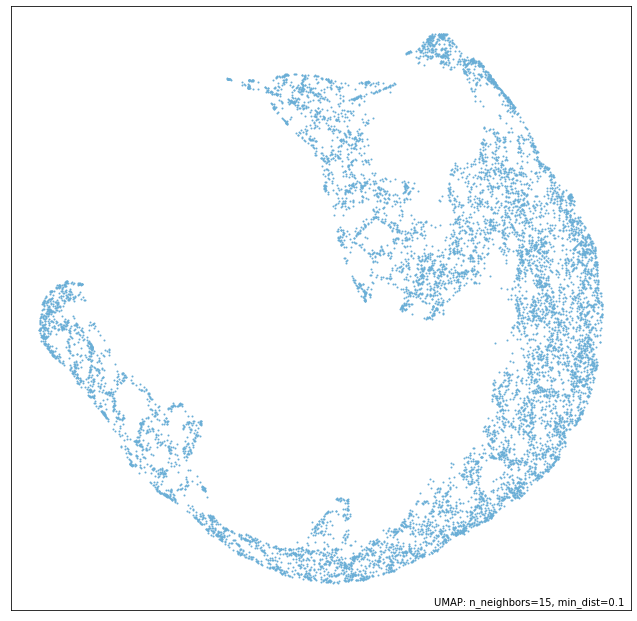

In [28]:
# Plot the embedding

umap.plot.points(mapper)


In [17]:
from astropy.io import fits

allstar_fits_filename = 'allStar-l31c.2.fits'
with fits.open(allstar_fits_filename) as hdulist:

    allstar = pd.DataFrame([hdulist[1].data['APOGEE_ID'],
                        hdulist[1].data['RA'],
                        hdulist[1].data['DEC'],
                        hdulist[1].data['TEFF'],
                        hdulist[1].data['LOGG'],
                        hdulist[1].data['O_FE'],
                        hdulist[1].data['C_FE'],
                        hdulist[1].data['M_H']], 
                        index = ['APOGEE_ID', 
                        'RA', 
                        'DEC',
                        'TEFF',
                        'LOGG',
                        'O_FE',
                        'C_FE',
                        'M_H'])

allstar = allstar.T
allstar = allstar.set_index('APOGEE_ID')
print(allstar.shape)
allstar = allstar[~allstar.index.duplicated(keep='first')]
print(allstar.shape)
allstar.head()

(277371, 7)
(258475, 7)


,RA,DEC,TEFF,LOGG,O_FE,C_FE,M_H
APOGEE_ID,,,,,,,
VESTA,0,0,5723.84,-9999,-0.0105972,0.0247771,0.0386801
2M00000002+7417074,0.000103,74.2854,3738.63,0.727419,0.0723792,0.0084211,-0.0681051
2M00000019-1924498,0.000832,-19.4139,5591.62,-9999,0.222009,0.0224563,-0.182092
2M00000032+5737103,0.001335,57.6195,6197.46,-9999,0.199215,0.0602879,-0.270533
2M00000068+5710233,0.00285,57.1732,4987.15,3.35494,-0.0528378,-0.120434,-0.122799


In [19]:
cws = allstar['TEFF'].values.astype(float)

In [24]:
print(len(cws))
subsample = np.where(cws > -9000)[0]
print(len(subsample))

258475
216056


In [78]:
# Issue is how to join labels with distance matrix points - the distance matrix doesn't appear to have labels

# Assuming now that the tsnecoor data set has the data in order 
tSNE_df = pd.read_csv('tsnecoor.dat.gz', delimiter='\s+', header=None, index_col=0 )
print(tSNE_df.shape)
tSNE_df.head()

print(tSNE_df.iloc[139707])

(193556, 2)
1    19.973024
2     0.459540
Name: 2M19415577+3919361, dtype: float64


In [107]:
# From Itamar - a way to map the tsne indices to the DR13 points


# Here's the mapping
dr13_locs = np.load('dr13_locs.npy')
print("dr13_locs size:",len(dr13_locs))
# cross objects are all the objects in DR13 that are also in DR14
# Returns all of the indices with such a mapping
cross_objs = np.where(dr13_locs >= 0)[0]
print("cross_objs size:",len(cross_objs))

dr13_locs_use = dr13_locs[cross_objs].astype(int)
print("locs_use:",len(dr13_locs_use))


nof_objects = data.shape[0]
print("# objects:",nof_objects)
# Need to populate this array so it's the same size as the data matrix
tsne_x_use_full = np.ones(nof_objects)*np.nan
tsne_y_use_full = np.ones(nof_objects)*np.nan
dr13_map_full = np.array(np.ones(nof_objects)*np.nan,dtype=str)
#print(dr13_map_full)

# Grabs indices of stars in tsnecoor
star_ident = np.array(tSNE_df.axes[0])
print("star-index length:",len(star_ident))

# I want to make an array dim long that has corresponding labels in order of DR13 matrix
# First way to do this is make an array of the right indices dim long
dr13_locs_use = star_ident[dr13_locs_use]
print("dr13 locs use:",len(dr13_locs_use))
dr13_map_full[cross_objs] = dr13_locs_use
print("full map size: ", len(dr13_map_full))



# THIS CODE IS USED TO VALIDATE THE METHOD:

# tsne_x = tSNE_df[1].values
# tsne_y = tSNE_df[2].values

# tsne_x_ = tsne_x[dr13_locs_use]
# tsne_x_use_full[cross_objs] = tsne_x_


# tsne_y_ = tsne_y[dr13_locs_use]
# tsne_y_use_full[cross_objs] = tsne_y_


# This code confirms this mapping

# rand_objs = numpy.random.choice(nof_objects, 10000)

# plt.figure(figsize = (15,7))
# plt.scatter(tsne_x_use_full[rand_objs], tsne_y_use_full[rand_objs])

# i = numpy.random.choice(nof_objects)
# ngbs = numpy.argsort(full_dmat[i])[:100]
# plt.scatter(tsne_x_use_full[ngbs], tsne_y_use_full[ngbs])

# xmn = -40
# xmx = 30
# xlim = [xmn, xmx]

# ymn = -50
# ymx = 55
# ylim = [ymn, ymx]
# plt.xlim(xlim)
# plt.ylim(ylim)
# plt.show()


dr13_locs size: 107390
cross_objs size: 106112
locs_use: 106112
# objects: 107390
star-index length: 193556
dr13 locs use: 106112
full map size:  107390


In [142]:
# Creating matrix with list of different attributes per star

# Convert dr13 mapping to df so I can merge attribute info with it
dr13_mapping = pd.DataFrame(dr13_map_full)
dr13_mapping.rename(columns={0:"ID"},inplace = True)
dr13_mapping.head()


# Create

# allstar_w_tsne = allstar.merge(tSNE_df, left_index=True, right_index=True, how = 'inner')
# print(allstar_w_tsne.shape)
# allstar_w_tsne.head()

dr13_attr = dr13_mapping.merge(allstar, left_on='ID', right_index=True, how="left")
print(dr13_attr.shape)
dr13_attr.head()


(107390, 8)


,ID,RA,DEC,TEFF,LOGG,O_FE,C_FE,M_H
0,2M19415577+3919361,295.482,39.3267,4807.37,3.17617,0.0245807,-0.0708137,0.127862
1,2M06082176+1351359,92.0907,13.86,4399.25,1.9477,0.0571017,-0.0237896,-0.255092
2,2M17173422+4236157,259.393,42.6044,5319.26,-9999,0.107098,-0.0109298,-0.0746212
3,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN


[4807.37158203 4399.24853516 5319.26318359 ...           nan 6190.79589844
           nan]


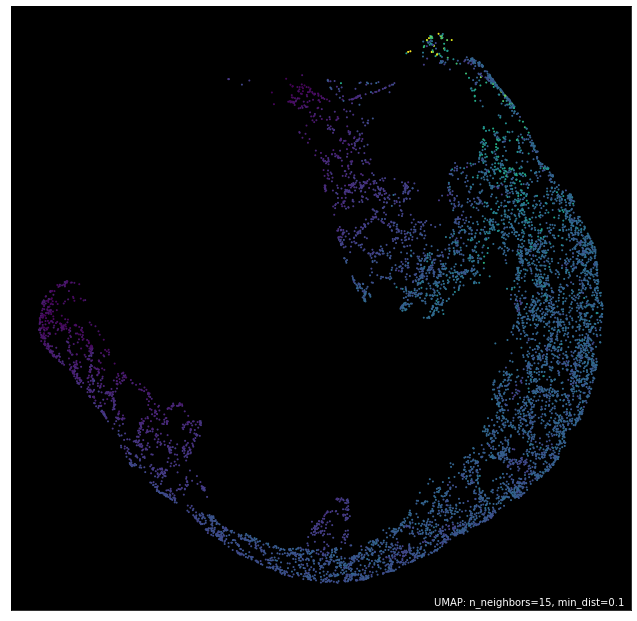

In [179]:
# Plotting with TEFF (effective temperature)


attrs = dr13_attr["TEFF"].values.astype(float)
attrs = np.where(attrs==-9999,np.nan,attrs)
print(attrs)
# I need to deal with the -9999 and NAN values
# Looks like range is 3000 to 8000
# Just for now let's set all in the middle



umap.plot.points(mapper, values=attrs[:dim], theme="viridis")


/opt/anaconda3/envs/umap-dev/lib/python3.8/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/opt/anaconda3/envs/umap-dev/lib/python3.8/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


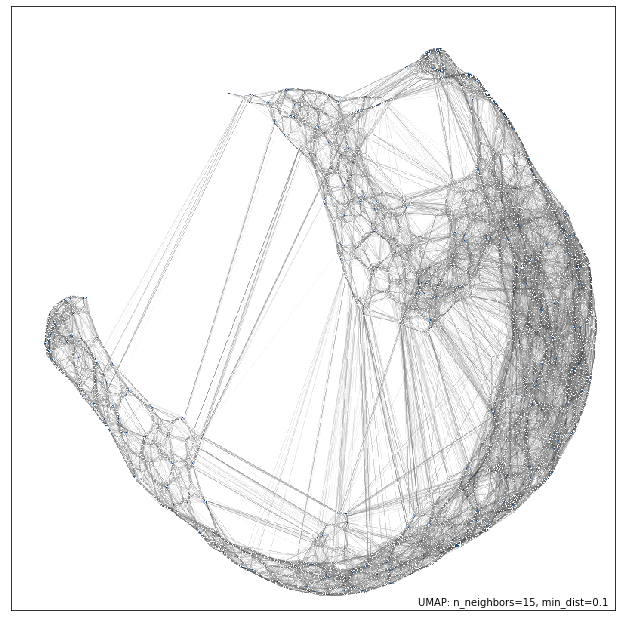

In [172]:
# Exploring how a connnectivity plot looks - can also do edge bundling, but computationally expensive

umap.plot.connectivity(mapper, show_points=True)

[ 1.27861962e-01 -2.55091518e-01 -7.46211559e-02 ... -9.99900000e+03
 -2.26093367e-01 -9.99900000e+03]
[ 0.12786196 -0.25509152 -0.07462116 ...         nan -0.22609337
         nan]


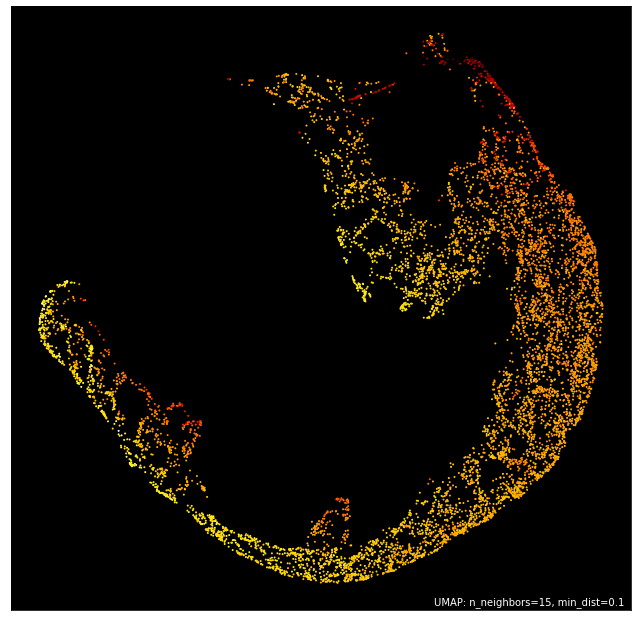

In [177]:
# Plotting Metallicity
attrs = dr13_attr['M_H'].values.astype(float)
print(attrs)
attrs = np.where(attrs==-9999,np.nan,attrs)
print(attrs)
# I need to deal with the -9999 and NAN values
# Looks like range is 3000 to 8000
# Just for now let's set all in the middle



umap.plot.points(mapper, values=attrs[:dim], theme="fire")


[ 3.17617130e+00  1.94770145e+00 -9.99900000e+03 ... -9.99900000e+03
 -9.99900000e+03 -9.99900000e+03]
[3.1761713  1.94770145        nan ...        nan        nan        nan]


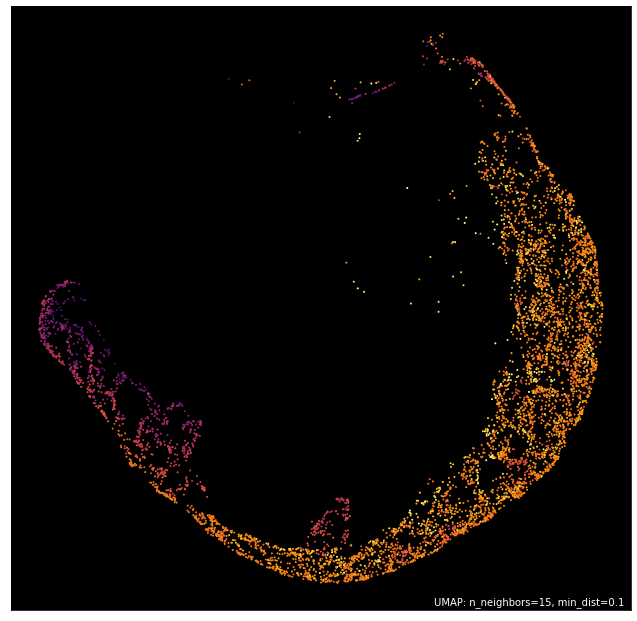

In [183]:
# Plotting Surface Gravity
attrs = dr13_attr['LOGG'].values.astype(float)
print(attrs)
attrs = np.where(attrs==-9999,np.nan,attrs)
print(attrs)
# I need to deal with the -9999 and NAN values
# Looks like range is 3000 to 8000
# Just for now let's set all in the middle



umap.plot.points(mapper, values=attrs[:dim], theme="inferno")

In [302]:
# Plot styling

# print(plt.style.available)
# ['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 
#  'fivethirtyeight', 'seaborn-whitegrid', 'classic', 
#  '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 
#  'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 
#  'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 
#  'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 
#  'seaborn-poster', 'seaborn-deep']
plt.style.use('default')


plt.rcParams['font.family'] = 'Avenir'
#plt.rcParams['font.size'] = 20
# plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['axes.edgecolor'] = 'black'
# plt.rcParams['axes.grid'] = False
# plt.rcParams['xtick.major.size'] = 5
# plt.rcParams['xtick.minor.size'] = 5
# plt.rcParams['ytick.major.size'] = 5
# plt.rcParams['ytick.minor.size'] = 5
# plt.rcParams['ytick.labelsize'] = 'large'
# plt.rcParams['ytick.color'] = 'black'
# plt.rcParams['xtick.labelsize'] = 'large'
# plt.rcParams['xtick.color'] = 'black'
# plt.rcParams['text.usetex'] = True



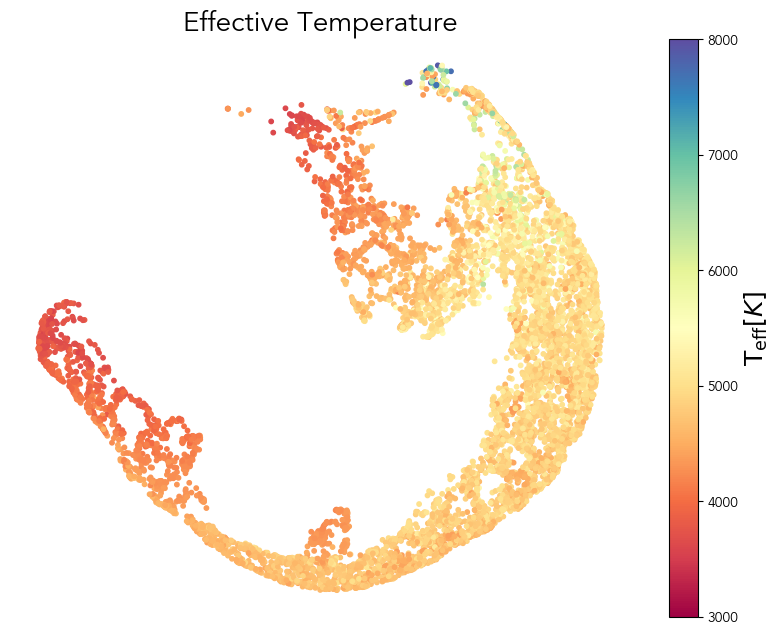

In [313]:
# Plotting Temp using pyplot

# I'm worred my nan values are throwing things off,
# I'll plot using the regular functionality to confirm

attrs = dr13_attr["TEFF"].values.astype(float)
attrs = np.where(attrs==-9999,np.nan,attrs)


points = mapper.embedding_
#print(points)
x_s = points[:,0]
y_s = points[:,1]
#print(x_s,y_s)

# Make a color map
cmin = 3000
cmax =  8000

plt.figure(figsize = (10,7.5))
plt.scatter(x_s,y_s,c=attrs[:dim],vmin=cmin, vmax=cmax,cmap='Spectral',s=10,alpha=1)
plt.title("Effective Temperature",fontsize=20)
cb = plt.colorbar()
cb.set_label('$\mathrm{T}_{\mathrm{eff}} [K]$',fontsize=18)
plt.axis('off')
plt.show()